**Install dependencies**

In [1]:
# %%capture
# !pip install -U torch torchvision torchaudio torcheval
# !pip install -U pillow numpy pandas gradio kaggle timm bitsandbytes tqdm
# !pip install -U cjm_pil_utils cjm_pytorch_utils cjm_kaggle_utils cjm_pandas_utils

**Import dependencies**

In [2]:
from pathlib import Path
import hashlib
import json
import random
import multiprocessing
import math
import os
from functools import partial
from copy import copy

import gradio as gr
from PIL import Image
import numpy as np
import timm

import pandas as pd
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import tqdm module for progress bars
from tqdm.notebook import tqdm

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torcheval.tools import get_module_summary

# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, iterate_modules, tensor_stats_df
from cjm_pandas_utils.core import markdown_to_pandas

**Enter Kaggle username and API token**

In [3]:
username = ""
key = ""

**Save Kaggle credentials to file**

In [4]:
save_kaggle_creds(username, key, overwrite=False)

Empty username.


**Define directory paths**

In [5]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


**Define Kaggle dataset**

In [6]:
# Set the name of the dataset
# dataset_name = 'pexels-110k-512p-min-jpg'
dataset_name = 'pexels-110k-768p-min-jpg'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/pexels-110k-768p-min-jpg.zip
Dataset Path: /mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg


**Download Kaggle dataset**

In [7]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

Dataset already downloaded


**Define path to image folder**

In [8]:
src_img_dir = Path(dataset_path/"images")
src_img_dir

PosixPath('/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images')

**Get source images**

In [9]:
# Get a list of the paths to the images in the images directory
src_img_paths = get_img_files(src_img_dir)

# Print the number of images in the images directory
print(len(src_img_paths))

109971


**Map image IDs to file paths**

In [10]:
# Create a dictionary mapping image IDs to image paths
src_img_path_dict = {path.stem.split('-')[-1] : path for path in src_img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(src_img_path_dict, orient='index').head()

,0
1061142,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/1-art-background-1061142.jpg
2586334,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/1-person-beauty-face-blurred-background-2586334.jpg
1460032,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/1-wtc-artist-concert-1460032.jpg
1061133,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/10-art-artistic-1061133.jpg
1339845,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/10-art-color-1339845.jpg


**Store list of image IDs**

In [11]:
img_ids = list(src_img_path_dict.keys())
len(img_ids)

109971

**Select a subset of image IDs for training**

In [12]:
img_ids_subset = img_ids
# img_ids_subset = random.sample(img_ids, 50)
len(img_ids_subset)

**Display sample image**

ID: 1727016


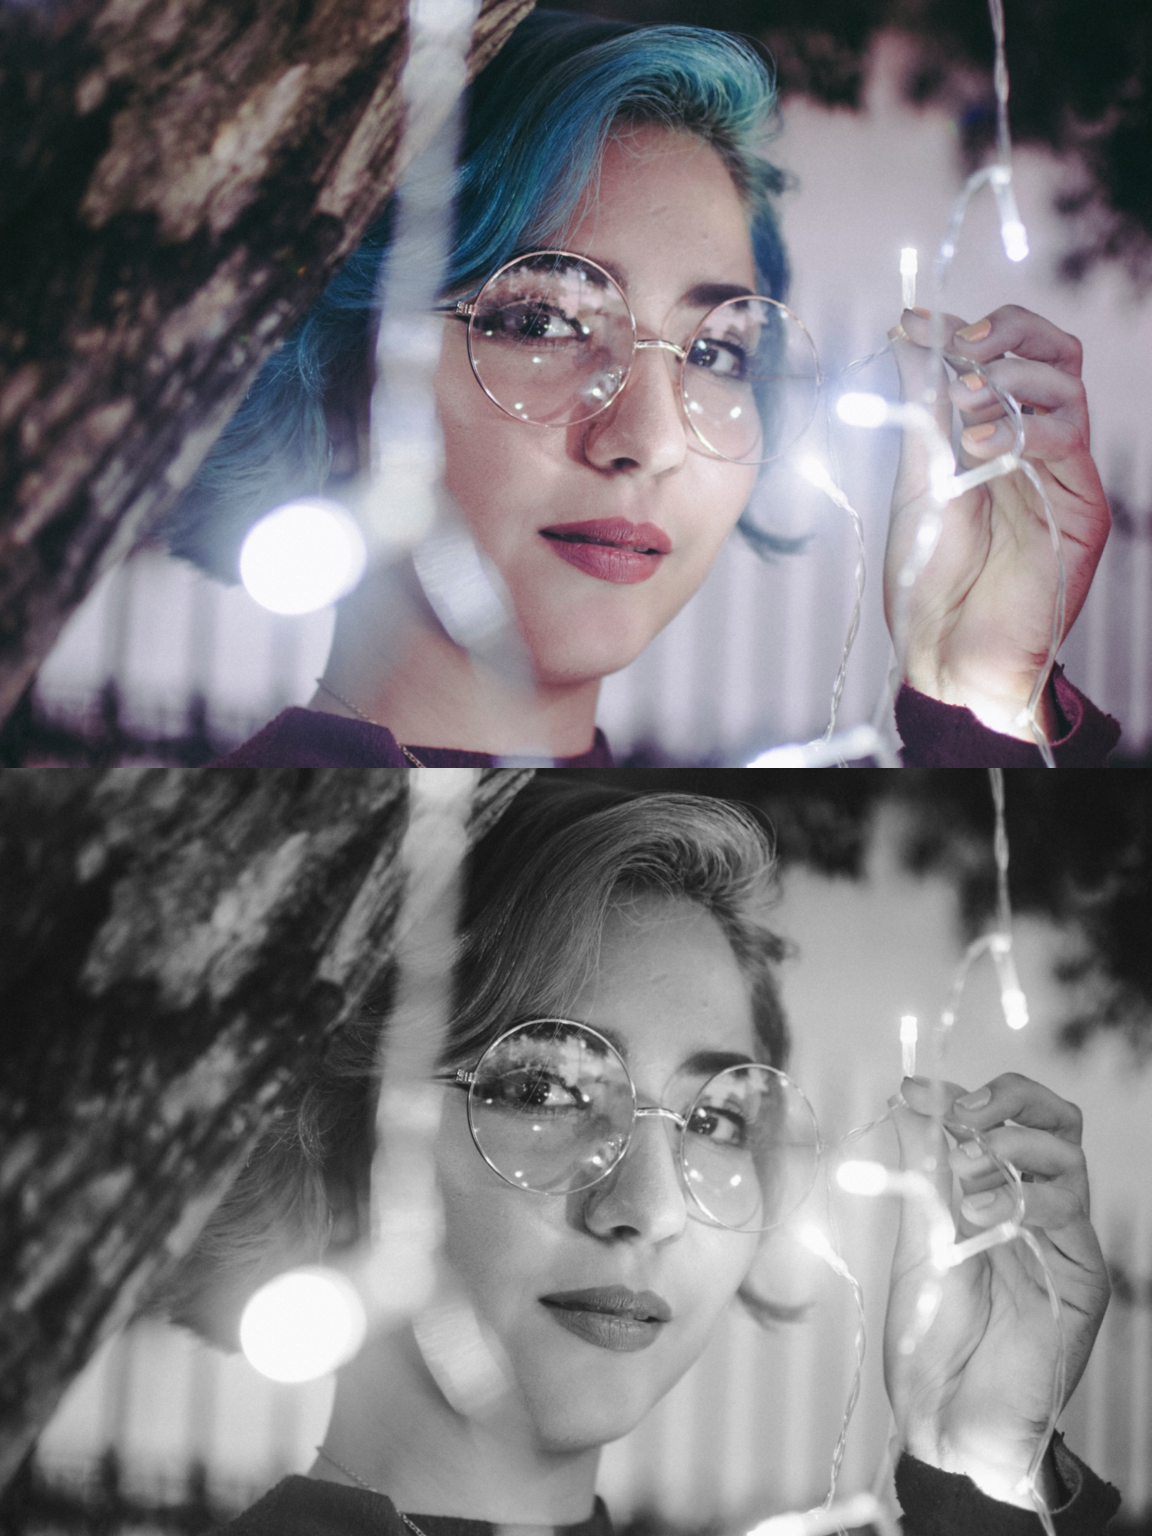

In [13]:
# Choose a random image ID from the list of image IDs
img_id = random.choice(img_ids_subset)

# img_id = '1391499'
# img_id = '2650631'
img_id = '1727016'

print(f"ID: {img_id}")

# Open the image located at the path in the img_path_dict with the key of the current img_id
img_path = src_img_path_dict[img_id]
sample_img = Image.open(img_path)

greyscale_img = sample_img.convert("L").convert("RGB")

# Display the image
stack_imgs([sample_img, greyscale_img])

**Select PyTorch compute device**

In [14]:
# Check if the MPS (Metal Performance Shaders) for MacOS is available, and if so, set the `device` variable to "mps"
# Otherwise, check if CUDA is available, and if so, set the `device` variable to "cuda"
# If neither MPS nor CUDA are available, set the `device` variable to "cpu"
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# Print the value of the `device` variable
print(device)

cuda


**Define model data type**

In [15]:
train_dtype = torch.float32

**Define style transfer model normalization stats**

In [16]:
# Normalize to the range [-0.5, 0.5]
norm_stats = [0.5], [1.0]

**Convert sample image to tensor**

In [17]:
# Convert image to a normalized and batched tensor 
img_tensor = pil_to_tensor(greyscale_img, *norm_stats).to(device=device, dtype=train_dtype)
tensor_stats_df(img_tensor)

,0
mean,-0.024832
std,0.246907
min,-0.441176
max,0.492157
shape,"(1, 3, 768, 1152)"


**Define training dataset class**

In [18]:
class ColorizeDataset():
    """
    Dataset for colorizing greyscale images.
    """
    def __init__(
        self,
        img_ids,
        src_img_path_dict,
        norm_stats,
        size=512,
        random_flip=False,
        center_crop=False,
    ):
        """
        Initialize the dataset.
        
        Parameters:
            img_ids (List): List of image IDs.
            src_img_path_dict (Dict): Dictionary of image IDs and corresponding image paths.
            norm_stats (Tuple): Mean and standard deviation for normalization.
            size (int, optional): Image size. Default: 512
            random_flip (bool, optional): Flag to random flip image. Default: False
            center_crop (bool, optional): Flag to center crop image. Default: False
        """
        self.img_ids = img_ids
        self.src_img_path_dict = src_img_path_dict
        
        self.size = size
        self.center_crop = center_crop
        
        # Compose a list of image transforms
        self.tfms_list = [
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(*norm_stats)
        ]
        
        if random_flip:
            # Add random horizontal flip to the transforms list
            self.tfms_list.insert(1, transforms.RandomHorizontalFlip(p=0.5))
        
        # Compose the final image transforms
        self.image_transforms = transforms.Compose(self.tfms_list)
        
    def __len__(self):
        """
        Return the length of the dataset.
        """
        return len(self.img_ids)
    
    def __getitem__(self, index):
        """
        Get the item at the specified index.
        
        Parameters:
            index (int): Index of the item to retrieve.
        
        Returns:
            torch.Tensor: Transformed image tensor.
        """
        img_id = self.img_ids[index % len(self.img_ids)]
        
        example = {}
        
        src_img_path = self.src_img_path_dict[img_id]
        src_img = Image.open(src_img_path)
        
        greyscale_img = src_img.convert("L").convert("RGB")
        
        return self.image_transforms(greyscale_img), self.image_transforms(src_img)

**Set training batch size**

In [19]:
bs = 4

**Initialize datasets**

In [20]:
train_sz = 296
# train_sz = 384
# train_sz = 512
# train_sz = 768

train_dataset = ColorizeDataset(
    img_ids=img_ids_subset,
    src_img_path_dict=src_img_path_dict,
    norm_stats=norm_stats,
    size=train_sz,
    random_flip=False,
    center_crop=True,
)

valid_dataset = copy(train_dataset)
valid_dataset.img_ids = img_ids_subset[-bs:]

len(train_dataset.img_ids), len(valid_dataset.img_ids)

(109971, 4)

**Inspect dataset sample**

In [21]:
tensor_stats_df(train_dataset[0][0])

,0
mean,0.100374
std,0.0559
min,-0.456863
max,0.5
shape,"(3, 296, 296)"


In [22]:
tensor_stats_df(train_dataset[0][1])

,0
mean,0.07255
std,0.311998
min,-0.488235
max,0.5
shape,"(3, 296, 296)"


**Initialize dataloader**

In [23]:
# Initializing the dataloader for train dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=bs, 
                                               shuffle=True, 
                                               num_workers=multiprocessing.cpu_count(), 
                                               pin_memory=True)

# Print the number of batches in the training and validation dataloaders
len(train_dataloader)#, #len(dls.valid)

27493

**Define style transfer model**

In [24]:
class ConvLayer(nn.Module):
    """
    Applies reflection padding followed by a 2D convolution operation.
    
    Parameters:
    in_channels (int): The number of input channels for the 2D convolution operation.
    out_channels (int): The number of output channels for the 2D convolution operation.
    kernel_size (int): The size of the convolution kernel.
    stride (int): The stride of the convolution operation.
    """
    def __init__(self, in_channels:int, out_channels:int, kernel_size:int, stride:int):
        super(ConvLayer, self).__init__()
        
        self.conv = nn.Sequential(nn.ReflectionPad2d(kernel_size // 2), 
                                  nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    def forward(self, x):
        return self.conv(x)
    
class ResBlock(nn.Module):
    """
    A residual block that consists of two convolutional layers followed by instance normalization,
    and an activation function, with the output of the block being added to the input.
    
    Parameters:
    channels (int): The number of channels in the input tensor.
    act (nn.Module, optional): The activation function. Defaults to nn.ReLU.
    """
    def __init__(self, channels:int, act:nn.Module=nn.ReLU):
        super(ResBlock, self).__init__()
        self.convs = nn.Sequential(
            ConvLayer(channels, channels, kernel_size=3, stride=1),
            nn.InstanceNorm2d(channels, affine=True),
            act(),
            ConvLayer(channels, channels, kernel_size=3, stride=1),
            nn.InstanceNorm2d(channels, affine=True),
        )

    def forward(self, x):
        return self.convs(x) + x

class DownsampleShuffle(nn.Module):
    """
    Performs downsampling using a reverse PixelShuffle operation.
    
    Parameters:
    in_channels (int): The number of channels in the input tensor.
    out_channels (int): The number of channels in the output tensor.
    scale (int, optional): The scale factor used for shuffling. Defaults to 2.
    act (nn.Module, optional): The activation function. Defaults to nn.ReLU.
    """
    def __init__(self, in_channels:int, out_channels:int, scale:int=2, act:nn.Module=nn.ReLU):        
        super(DownsampleShuffle, self).__init__()
        
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels//(scale**2), kernel_size=1, stride=1), 
                                        act(),
                                        nn.PixelUnshuffle(scale))
    def forward(self, x):
        return self.downsample(x)

class UpsampleShuffle(nn.Module):
    """
    Performs upsampling layer using a PixelShuffle operation.
    
    Parameters:
    in_channels (int): The number of channels in the input tensor.
    out_channels (int): The number of channels in the output tensor.
    scale (int, optional): The scale factor used for shuffling. Defaults to 2.
    act (nn.Module, optional): The activation function. Defaults to nn.ReLU.
    """
    def __init__(self, in_channels:int, out_channels:int, scale:int=2, act:nn.Module=nn.ReLU):
        super(UpsampleShuffle, self).__init__()
        
        self.upsample = nn.Sequential(nn.Conv2d(in_channels, out_channels*(scale**2), kernel_size=1, stride=1), 
                                      act(), 
                                      nn.PixelShuffle(scale))
    def forward(self, x):
        return self.upsample(x)

In [25]:
# class FastNeuralStyleNet(nn.Module):
#     def __init__(self, chnls=[32,64,128], res_blocks=5, act=nn.ReLU):
#         """
#         Parameters:
#         chnls (list, optional): List of channels. Default is [32, 64, 128].
#         res_blocks (int, optional): Number of residual blocks. Default is 5.
#         act (nn.Module, optional): Activation function. Default is nn.ReLU.
#         """
#         super(FastNeuralStyleNet, self).__init__()
        
#         # Input layers
#         self.inp_layers = nn.Sequential(ConvLayer(3, chnls[0], kernel_size=3, stride=1), 
#                                         nn.InstanceNorm2d(chnls[0], affine=True), 
#                                         act())
        
#         # Downsampling
#         self.downsample = nn.Sequential(*[nn.Sequential(DownsampleShuffle(chnls[i], chnls[i+1], scale=2), 
#                                                         nn.InstanceNorm2d(chnls[i+1], affine=True),
#                                                         act()) for i in range(len(chnls)-1)])
#         # Residual Blocks
#         self.res_blocks = nn.Sequential(*[ResBlock(chnls[-1]) for _ in range(res_blocks)])
        
#         # Upsampling
#         self.upsample = nn.Sequential(*[nn.Sequential(UpsampleShuffle(chnls[i]*2, chnls[i-1], scale=2), 
#                                                       nn.InstanceNorm2d(chnls[i-1], affine=True), 
#                                                       act()) for i in range(len(chnls)-1, 0, -1)])
#         # Output layers
#         self.out_layers = nn.Sequential(ConvLayer(chnls[0], 3, kernel_size=3, stride=1), 
#                                         nn.Sigmoid())
        
#     def forward(self, X):
        
#         # Downsampling
#         down_out = [self.inp_layers(X)]
#         for i, downsample in enumerate(self.downsample):
#             down_out.append(downsample(down_out[i]))
#         down_out.reverse() 
        
#         # Residual Blocks
#         up_out = [self.res_blocks(down_out[0])]
        
#         # Upsampling
#         for i, upsample in enumerate(self.upsample):
#             up_out.append(upsample(torch.cat([down_out[i], up_out[i]], dim=1)))
            
#         return self.out_layers(up_out[-1])

In [26]:
class FastNeuralStyleNet(nn.Module):
    def __init__(self, chnls=[32,64,128], res_blocks=5, act=nn.ReLU):
        """
        Parameters:
        chnls (list, optional): List of channels. Default is [32, 64, 128].
        res_blocks (int, optional): Number of residual blocks. Default is 5.
        act (nn.Module, optional): Activation function. Default is nn.ReLU.
        """
        super(FastNeuralStyleNet, self).__init__()
        
        # Input layers
        self.inp_layers = nn.Sequential(ConvLayer(3, chnls[0], kernel_size=3, stride=1), 
                                        nn.InstanceNorm2d(chnls[0], affine=True), 
                                        act())
        
        # Downsampling
        self.downsample = nn.Sequential(*[nn.Sequential(DownsampleShuffle(chnls[i], chnls[i+1], scale=2), 
                                                        nn.InstanceNorm2d(chnls[i+1], affine=True),
                                                        act()) for i in range(len(chnls)-1)])
        # Residual Blocks
        self.res_blocks = nn.Sequential(*[ResBlock(chnls[-1]) for _ in range(res_blocks)])
        
        self.cross_convs = nn.ModuleList([ResBlock(n) for n in chnls[::-1]])
        
        # Upsampling
        self.upsample = nn.Sequential(*[nn.Sequential(UpsampleShuffle(chnls[i]*2, chnls[i-1], scale=2), 
                                                      nn.InstanceNorm2d(chnls[i-1], affine=True), 
                                                      act()) for i in range(len(chnls)-1, 0, -1)])
        # Output layers
        self.out_layers = nn.Sequential(ConvLayer(chnls[0], 3, kernel_size=3, stride=1), 
                                        nn.Sigmoid())
        
    def forward(self, X):
        
        # Downsampling
        down_out = [self.inp_layers(X)]
        for i, downsample in enumerate(self.downsample):
            down_out.append(downsample(down_out[i]))
        down_out.reverse() 
        
        # Residual Blocks
        up_out = [self.res_blocks(down_out[0])]
        
        # Upsampling
        for i, upsample in enumerate(self.upsample):
            up_out.append(upsample(torch.cat([self.cross_convs[i](down_out[i]), up_out[i]], dim=1)))
            
        return self.out_layers(up_out[-1])

**Instantiate style transfer model**

In [27]:
chnls=[16,32,64]
# chnls=[32,64,128]
style_transfer_model = FastNeuralStyleNet(chnls=chnls, res_blocks=40).to(device)

**Initialize model weights**

In [28]:
layer_type = nn.modules.conv.Conv2d
# Find all Conv2d layers in the model
conv_list = [module for module in iterate_modules(style_transfer_model) if type(module) == layer_type]

res_blocks = []
for conv in conv_list:
    # Initialize the weights of all Conv2d layers
    nn.init.kaiming_normal_(conv.weight)
    # Find all Conv2d layers in the res_blocks
    if conv.in_channels == chnls[-1]:
        res_blocks.append(conv)
        
# Zero out the weights of every second Conv2d layer in res_blocks
for i, conv in enumerate(res_blocks[:-1]):
    if i%2 != 0:
        conv.weight.data.zero_()

# Zero out the weights of the last Conv2d layer
conv_list[-1].weight.data.zero_();

**Get model summary**

In [29]:
# Define the input to the model
test_inp = torch.randn(1, 3, *[train_dataset.size]*2).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(style_transfer_model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs,Backward FLOPs,In size,Out size
0,FastNeuralStyleNet,3.1 M,3.1 M,12.3 M,17.2 G,34.4 G,"[1, 3, 296, 296]","[1, 3, 296, 296]"
5,Conv2d,448,448,1.8 K,37.9 M,37.9 M,"[1, 3, 298, 298]","[1, 16, 296, 296]"
12,Conv2d,136,136,544,11.2 M,22.4 M,"[1, 16, 296, 296]","[1, 8, 296, 296]"
20,Conv2d,528,528,2.1 K,11.2 M,22.4 M,"[1, 32, 148, 148]","[1, 16, 148, 148]"
31,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"
37,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"
44,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"
50,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"
57,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"
63,Conv2d,36.9 K,36.9 K,147 K,201 M,403 M,"[1, 64, 76, 76]","[1, 64, 74, 74]"


**List available ConvNeXt Nano models**

In [30]:
pd.DataFrame(timm.list_models('convnext_nano*', pretrained=True))

,0
0,convnext_nano
1,convnext_nano_ols


**Inspect config for convnext model**

In [31]:
# Import the convnext module
from timm.models import convnext

# Choose the convnext model
convnext_model = 'convnext_nano'

# Get the default configuration of the chosen model as a Pandas DataFrame
pd.DataFrame.from_dict(convnext.default_cfgs[convnext_model], orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/convnext_nano_d1h-7eb4bdea.pth
num_classes,1000
input_size,"(3, 224, 224)"
pool_size,"(7, 7)"
crop_pct,0.95
interpolation,bicubic
mean,"(0.485, 0.456, 0.406)"
std,"(0.229, 0.224, 0.225)"
first_conv,stem.0
classifier,head.fc


**Load `convnext_nano` model**

In [32]:
# Load the convnext model
convnext = timm.create_model(convnext_model, pretrained=True).to(device)

# Set the device and data type
convnext = convnext.to(device=device, dtype=train_dtype).eval()
convnext.device = device

# Disable gradient calculation for the parameters
for param in convnext.parameters():
    param.requires_grad = False

**Select layers for perceptual loss**

In [33]:
# Define the layer type to search for
layer_type = timm.models.layers.activations.GELU

# Get a list of modules in the perception model
modules_list = list(iterate_modules(convnext))

# Initialize an empty list to store the indices of modules of the desired type
convnext_feat_layers = []

# Loop through the modules in the list
for i, module in enumerate(modules_list):
    if type(module) == layer_type:
        convnext_feat_layers.append(i)
convnext_feat_layers

[13, 23, 38, 48, 63, 73, 83, 93, 103, 113, 123, 133, 148, 158]

**Load VGG model**

In [34]:
# Load a VGG model
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
# vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features

# Set the device and data type
vgg = vgg.to(device=device, dtype=train_dtype).eval()
vgg.device = device

# Disable gradient calculation for the parameters
for param in vgg.parameters():
    param.requires_grad = False

**Select layers for perceptual loss**

In [35]:
# Define the layer type to search for
layer_type = nn.modules.activation.ReLU
pool_type = nn.modules.pooling.MaxPool2d

# Get a list of modules in the perception model
modules_list = list(iterate_modules(vgg))

# Initialize an empty list to store the indices of modules of the desired type
vgg_feat_layers = []

# Loop through the modules in the list
for i, module in enumerate(modules_list):
    if type(module) == layer_type:# and type(modules_list[i+1]) == pool_type:
        vgg_feat_layers.append(i)
vgg_feat_layers

[1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29]

**Select perception model**

In [36]:
perception_model = convnext
feat_layers = convnext_feat_layers

# perception_model = vgg
# feat_layers = vgg_feat_layers

**Define wrapper class for PyTorch hooks**

In [37]:
class Hook():
    """
    Hook class that registers a forward hook to the specified module and
    implements methods to remove the hook and clean up resources.
    """
    def __init__(self, m, f): 
        """
        Parameters:
        m: The PyTorch module to which the hook is attached.
        f: The hook function to be registered to the module.
        """
        self.hook = m.register_forward_hook(partial(f, self))
        
    def remove(self): 
        """
        Remove the hook from the module.
        """
        self.hook.remove()
    
    def __del__(self): 
        """
        Clean up resources.
        """
        self.remove()

**Define hook function to store module outputs**

In [38]:
def hook_fn(hook, module, inp, out):
    # Store the output of the module
    hook.outputs = out

**Implement perceptual style loss**

In [39]:
class PerceptualLoss():
    """
    Use a pre-trained perception model to extract features from the input tensors,
    and compares these features to calculate the content loss and style loss.
    """
    def __init__(self, 
                 perception_model:nn.Module, 
                 norm_stats:tuple, 
                 hook_fn, 
                 feat_layers:list,
                 content_wt:float=1e5):
        """
        Parameters:
        perception_model: A pre-trained deep learning model to be used for extracting features.
        norm_stats: The normalization statistics for the input tensor.
        hook_fn: A function to store the output of the intermediate layers.
        feat_layers: List of layer indices to be used for feature extraction.
        content_wt: The weight for the content loss.
        """
        self.perception_model = perception_model
        self.norm_stats = norm_stats
        self.hook_fn = hook_fn
        self.feat_layers = feat_layers
        self.content_wt = content_wt
        
        self.hooks = []
        self.hook_perception_model()
        
    def hook_perception_model(self):
        """
        Attach hooks to the specified layers in the perception model.
        """
        modules_list = list(iterate_modules(self.perception_model))
        self.hooks = [Hook(modules_list[layer], self.hook_fn) for layer in self.feat_layers]
                
    def get_features(self, inp_tensor:torch.Tensor):
        """
        Extract features from the input tensor using the perception model.
        """
        if self.perception_model.device == 'cuda':
            with torch.cuda.amp.autocast():
                self.perception_model(inp_tensor)
        else:
            self.perception_model(inp_tensor)
        features = [hook.outputs.float() for hook in self.hooks]
        return features
    
    def __call__(self, x:torch.Tensor, y:torch.Tensor):
        """
        Calculate the content loss
        """
        features_x = self.get_features(transforms.Normalize(*self.norm_stats)(x+0.5))
        features_y = self.get_features(transforms.Normalize(*self.norm_stats)(y))
        
        content_loss = 0.
        for i, (ft_y, ft_x) in enumerate(zip(features_y, features_x)):
            content_loss += nn.functional.mse_loss(ft_y, ft_x)
        content_loss *= self.content_wt
        
        return content_loss

**Define perception model normalization stats**

In [40]:
imagenet_stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

**Instantiate loss function**

In [41]:
# ConvNeXt
# content_weight = 1e2

# VGG Weights
content_weight = 1e5

perceptual_style_loss = PerceptualLoss(perception_model=perception_model, 
                                            norm_stats=imagenet_stats,  
                                            hook_fn=hook_fn, 
                                            feat_layers=feat_layers,
                                            content_wt=content_weight)

**Define path to store model checkpoints**

In [42]:
# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path("./colorize_checkpoints/")
checkpoint_dir.mkdir(parents=True, exist_ok=True)


# Create a name for the checkpoint based on the dataset and style image names and the training size
checkpoint_name = f"{dataset_path.stem.lower()}-{train_sz}p"
checkpoint_path = Path(checkpoint_dir/f"{checkpoint_name}")
checkpoint_path.mkdir(parents=True, exist_ok=True)

# Define the path to save the trained model
model_path = Path(checkpoint_path/"model.pth")

# Print the checkpoint path
checkpoint_path

PosixPath('colorize_checkpoints/pexels-110k-768p-min-jpg-296p')

**Configure training parameters**

In [43]:
# Max learning rate
learning_rate = 5e-3
# Total number of training epochs
epochs = 10
# Total number of training steps to perform.  If provided, overrides epochs.
max_train_steps = len(img_ids_subset) * epochs
# Number of batches between checkpoints
checkpoint_interval = 500

**Select optimizer**

In [44]:
# # Use 8-bit Adam for lower memory usage when available
# # https://github.com/TimDettmers/bitsandbytes
# try:
#     import bitsandbytes as bnb
#     optimizer_class = bnb.optim.AdamW8bit
# except ImportError:
#     optimizer_class = torch.optim.AdamW
# print(f"Optimizer Class: {optimizer_class.__name__}")

# optimizer = optimizer_class(style_transfer_model.parameters(), lr=learning_rate, eps=1e-3)

optimizer = torch.optim.AdamW(style_transfer_model.parameters(), lr=learning_rate, eps=1e-5)

**Set up learning rate scheduler**

In [45]:
# Calculate the number of steps per epoch
steps_per_epoch = math.ceil(max_train_steps/epochs/bs)

# Initialize the OneCycleLR learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=learning_rate, 
                                                   steps_per_epoch=steps_per_epoch, 
                                                   epochs=epochs)

**Train the style transfer model with NVIDIA's Automatic Mixed Precision**

In [46]:
# Load the GradScaler
scaler = torch.cuda.amp.GradScaler()

# Loop over each epoch
for epoch in tqdm(range(epochs)):
    
    # Set the style transfer model to train mode
    style_transfer_model.train()
    # Initialize the aggregate loss
    agg_loss = 0
    
    # Create a progress bar for the train data loader
    progress_bar = tqdm(range(len(train_dataloader)))
    progress_bar.set_description("Steps")
    
    # Loop over each batch of the data loader
    for batch_id, batch in enumerate(train_dataloader):
        
        # Move the batch to the GPU
        model_inp = batch[0].to(device=device)
        # Use autocast to cast the model inputs to half precision
        with torch.cuda.amp.autocast():
            # Pass the model inputs through the style transfer model
            model_pred = style_transfer_model(model_inp)
        
        # Compute the loss using the perceptual style loss function
        loss = perceptual_style_loss(batch[1].to(device=device), model_pred)
        
        # Backpropagate the loss and scale it using the GradScaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        
        # Step the learning rate scheduler
        lr_scheduler.step()
            
        # Update the progress bar
        progress_bar.update(1)
        # Add the loss to the aggregate loss
        agg_loss += loss.detach().item()
        # Create a dictionary of logs to display in the progress bar
        logs = {"loss": loss.detach().item(), 
                "avg_loss": agg_loss/(batch_id+1), 
                "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        
        # Break the training loop if the loss is NaN or infinite
        if loss.detach().isnan() or loss.detach().isinf(): break
            
        # Save the model and intermediate images at checkpoint intervals
        if batch_id != 0 and batch_id%checkpoint_interval == 0:
            with torch.no_grad():
                pred = style_transfer_model(img_tensor)
            test_img = tensor_to_pil(pred.squeeze())
            test_img.save(checkpoint_path/f"epoch-{epoch}-batch-{batch_id}.png", fmt="PNG")
            torch.save(style_transfer_model.state_dict(), 
                       Path(checkpoint_path/f"model-epoch-{epoch}-batch-{batch_id}.pth"))
            
    # Break the training loop if the loss is NaN or infinite
    if loss.detach().isnan() or loss.detach().isinf(): break
        
# Releases all unoccupied cached memory
torch.cuda.empty_cache()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/27493 [00:00<?, ?it/s]

/home/innom-dt/mambaforge/envs/sd-testing/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/27493 [00:00<?, ?it/s]

  0%|          | 0/27493 [00:00<?, ?it/s]

  0%|          | 0/27493 [00:00<?, ?it/s]

  0%|          | 0/27493 [00:00<?, ?it/s]

  0%|          | 0/27493 [00:00<?, ?it/s]

  0%|          | 0/27493 [00:00<?, ?it/s]

  0%|          | 0/27493 [00:00<?, ?it/s]

  0%|          | 0/27493 [00:00<?, ?it/s]

  0%|          | 0/27493 [00:00<?, ?it/s]

**Configure style transfer model for inference**

In [89]:
# Set the data type for the tensors used in the model
infer_dtype = torch.float16

# Move the model to the designated device and set it in evaluation mode
style_transfer_model.to(device=device, dtype=infer_dtype)
style_transfer_model.eval()

# Set the size of the image to be used during inference
infer_sz = 512

**Colorize a greyscale image using the style transfer model**

ID: 1147810
New Dimensions: (512, 768)


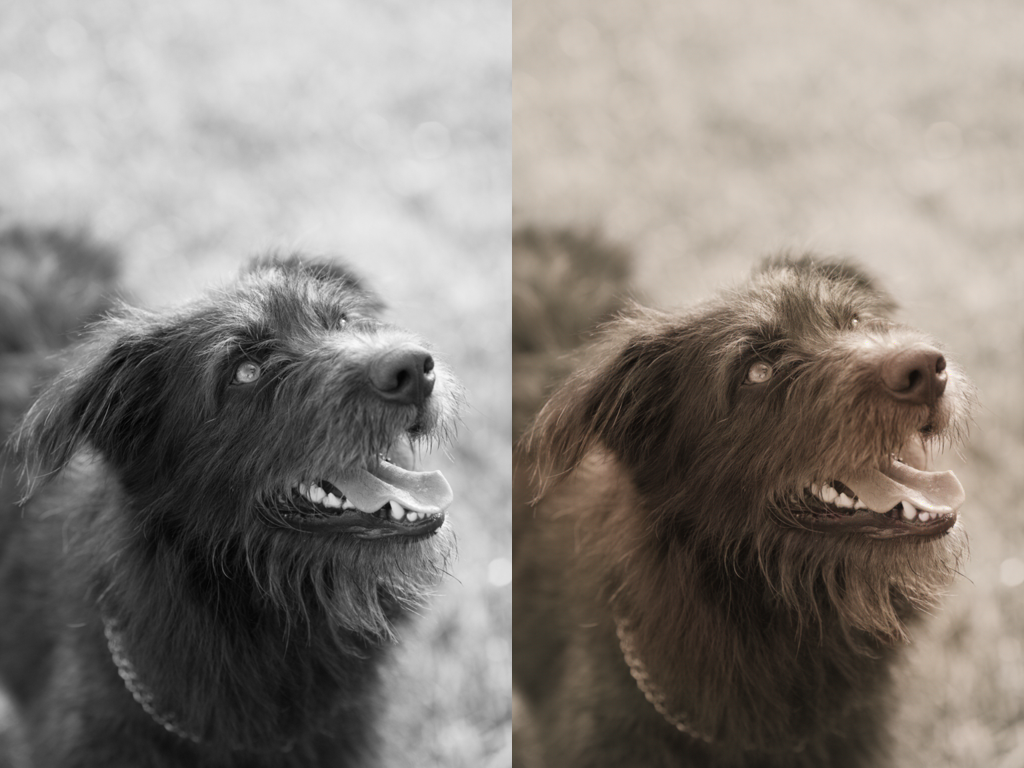

In [121]:
# Select a random image ID from the subset of available IDs
img_id = random.choice(img_ids_subset)
# img_id = "1536428"

# Print the selected image ID
print(f"ID: {img_id}")

# Get the file path of the selected image using the dictionary
img_path = src_img_path_dict[img_id]

# Open the selected image
sample_img = Image.open(img_path).convert("L").convert("RGB")

# Resize the image to the desired size
sample_img = resize_img(sample_img, target_sz=infer_sz, divisor=8)

# Print the new dimensions of the image
print(f"New Dimensions: {sample_img.size}")

# Convert the image to a tensor
img_tensor = pil_to_tensor(sample_img, *norm_stats).to(device=device, dtype=infer_dtype)

# Run the image through the style transfer model and store the result in `pred`
with torch.no_grad():
    pred = style_transfer_model(img_tensor)

# Convert the output tensor to an image
stylized_img = tensor_to_pil(pred.squeeze())

# Stack the original image and the stylized image together
stack_imgs([sample_img, stylized_img])

In [49]:
stop

NameError: name 'stop' is not defined

**Export PyTorch modle to ONNX format**

In [ ]:
# Set the ONNX opset version
onnx_opset = 12

# Export the model in both fp16 and fp32 precision
for dtype in [torch.float16, torch.float32]:
    style_transfer_model = style_transfer_model.to(dtype=dtype)
    img_tensor = img_tensor.to(dtype=dtype);
    
    # Get the string representation of the data type
    type_str = f"{dtype}".split('.')[-1]
    
    # Define the file path of the exported ONNX model
    onnx_file_path = Path(checkpoint_dir/f"{checkpoint_path.stem}/model-{type_str}-opset-{onnx_opset}.onnx")
    
    # Export the PyTorch model to ONNX format
    torch.onnx.export(style_transfer_model,
                  img_tensor,
                  onnx_file_path,
                  export_params=True,
                  opset_version=onnx_opset,
                  do_constant_folding=False
                 )